In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')
PWD = '/content/drive/My Drive/ML/Fashies/data/'
data = pd.read_csv(PWD+'train.csv',sep=';')
# read dataset
#data = pd.read_csv('../../../force2020_train.csv',sep=';')
print (data.shape)

Mounted at /content/drive
(1170511, 29)


In [4]:
data['WELL'].unique().shape

(98,)

In [5]:
#categorical logs, count them
print ('Wells:',data['WELL'].value_counts().shape[0])
print ('Group:',data['GROUP'].value_counts().shape[0])
print ('FORMATION:',data['FORMATION'].value_counts().shape[0])

Wells: 98
Group: 14
FORMATION: 69


In [6]:
# count features
train_logs = dict(100 - data.isna().sum()/data.shape[0] * 100)
train_logs = {log:value for log,value in train_logs.items() if value!=100}
train_logs

{'BS': 58.32128019300972,
 'CALI': 92.49242424889643,
 'DCAL': 25.530131711705394,
 'DRHO': 84.3953623673763,
 'DTC': 93.09164971538073,
 'DTS': 14.91767270875711,
 'FORCE_2020_LITHOFACIES_CONFIDENCE': 99.98470753371818,
 'FORMATION': 88.29622276082839,
 'GROUP': 99.89081691671416,
 'MUDWEIGHT': 27.0096564662784,
 'NPHI': 65.3910129849271,
 'PEF': 57.38450984228256,
 'RDEP': 99.05895801064663,
 'RHOB': 86.22234220780497,
 'RMED': 96.66871990096632,
 'RMIC': 15.049837207851951,
 'ROP': 45.712599027262456,
 'ROPA': 16.430857975704626,
 'RSHA': 53.878177992346934,
 'RXO': 27.972996409260574,
 'SGR': 5.925019072866462,
 'SP': 73.83501735566773,
 'X_LOC': 99.07946187605242,
 'Y_LOC': 99.07946187605242,
 'Z_LOC': 99.07946187605242}

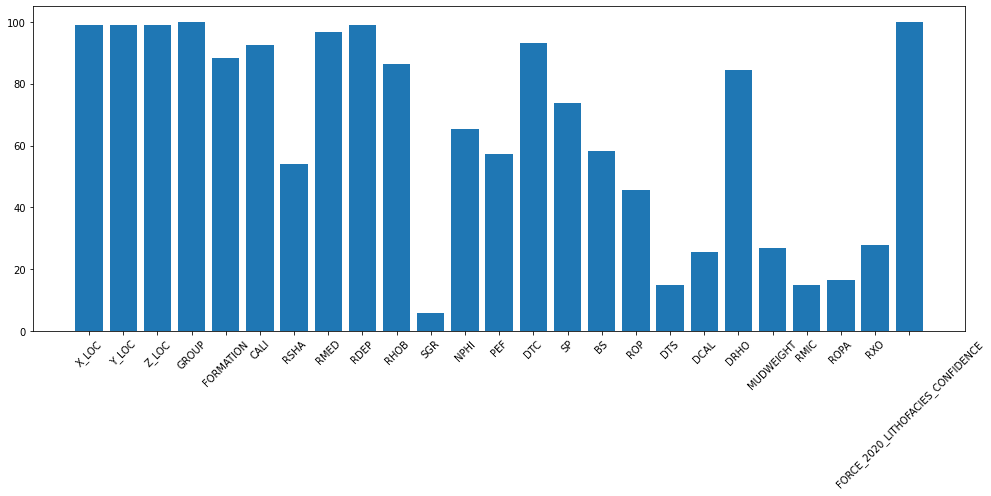

In [7]:
plt.figure(figsize=(14,7))
plt.bar(train_logs.keys(),train_logs.values())
plt.xticks(list(train_logs.keys()),rotation=45)
plt.tight_layout()

Text(0, 0.5, 'Well presence (\\%)')

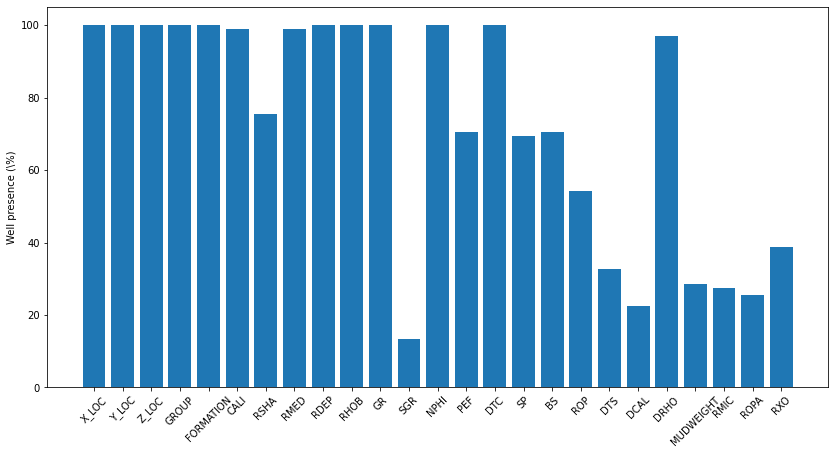

In [8]:
# check logs and find percentage of logs in wells
occurences = np.zeros(25) # exluding wells, FORCE litho colums 
for well in data['WELL'].unique():
    occurences += data[data['WELL']==well].isna().all().astype(int).values[2:-2] 
    # took columns with missing
fig,ax = plt.subplots(1,1,figsize=(14,7))
ax.bar(x=np.arange(occurences.shape[0]), height = (data.WELL.unique().shape[0]-occurences)/\
       data.WELL.unique().shape[0]*100.0)
ax.set_xticklabels(data.columns[2:-2],rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Well presence (\%)')

{65000: 720803, 30000: 168937, 65030: 150455, 70000: 56320, 80000: 33329, 99000: 15245, 70032: 10513, 88000: 8213, 90000: 3820, 74000: 1688, 86000: 1085, 93000: 103}


<BarContainer object of 12 artists>

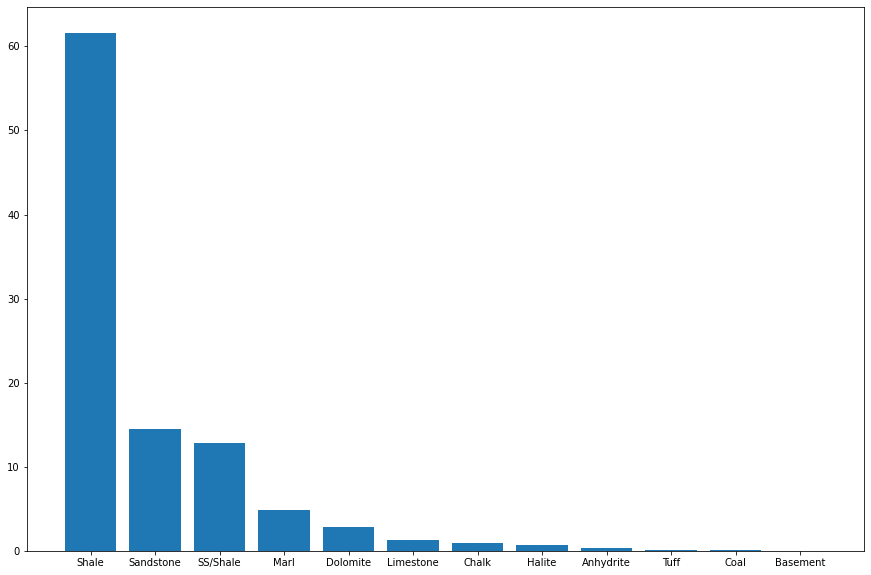

In [9]:
# lets explore labels, targets 
labels = dict(data.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts())
lithofacies_names = ['Shale','Sandstone','SS/Shale','Marl','Dolomite','Limestone','Chalk',
                    'Halite','Anhydrite','Tuff','Coal','Basement']
print (labels)

lithofacies_perc = np.array(list(labels.values()))/data.shape[0]*100
fig = plt.figure(figsize=(15,10))
plt.bar(lithofacies_names,lithofacies_perc)
# shale class dominated, imbalanced skewed, if the blind test not inbalanced like train data(shale 60%) 
#we will get overfit because we learn from imbalaned dataset

In [11]:
lithology_keys = {30000: 'Sandstone',65030: 'Sandstone/Shale',65000: 'Shale',80000: 'Marl',
                 74000: 'Dolomite',70000: 'Limestone',70032: 'Chalk',88000: 'Halite',86000: 'Anhydrite',
                 99000: 'Tuff', 90000: 'Coal', 93000: 'Basement'}
lithologies = {30000: 0,65030: 1,65000: 2,80000: 3, 74000: 4,70000: 5,70032: 6,88000: 7,
                  86000: 8, 99000: 9, 90000: 10, 93000: 11}

data['FaciesLabels'] = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)
data['Facies'] = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithologies)
data['Facies'] = data['Facies'].astype(int)
data.iloc[:3,-4:]

,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,FaciesLabels,Facies
0,65000,1.0,Shale,2
1,65000,1.0,Shale,2
2,65000,1.0,Shale,2


hold back from train data, we hold valid data and test data
<br> validation set -- main goal to avoid overfitting. get early estimate of error
<br>  ML model to better evaluate in blind data
<br>  no guide about blind data --> chooseing randomly from train data
<br>  model skill on train data  --biased score, hold-out set to get unbiased score (train-test split approach)
<br>  train - fit params
<br>  valid - tune params, helps in feature selections
<br>  valid - k-fold cross-valid to tune
<br>  test  - assess the model perfomance

In [12]:
# create validation well lists
np.random.seed(12)
wells = data.WELL.unique() # get all  well names
valid1 = random.sample(list(wells),10)
wells = [well for well in wells if not well in valid1] # drop previous 100 wells
valid2 = random.sample(list(wells),10)
wells = [well for well in wells if not well in valid2]
valid_wells = set(valid1+valid2)
print (len(valid1),len(valid2),len(wells),len(valid_wells))

10 10 78 20


In [13]:
# pull valid df
def valid_df(df,nwell):
    validation = pd.DataFrame(columns=list(df.columns))
    for well in nwell:
        welldata = df.loc[df.WELL==well]
        validation = pd.concat([welldata,validation])
    return validation

In [14]:
# get validations data
validation1 = valid_df(data,valid1)
validation2 = valid_df(data,valid2)
# total valid 
validation_data = pd.concat([validation1,validation2])

In [15]:
print (validation_data.shape,validation1.shape,validation2.shape)

(200608, 31) (125162, 31) (75446, 31)


In [16]:
# drop validations from train
newdata = pd.concat([data,validation_data,validation_data]).drop_duplicates(keep=False)
print (data.shape,newdata.shape)
# QC that no leakage, no doublicates 

(1170511, 31) (969903, 31)


In [17]:
print (data.shape)
print (validation_data.shape[0] + newdata.shape[0])

(1170511, 31)
1170511


In [18]:
newdata.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts()

65000    605469
30000    137346
65030    115990
70000     45572
80000     27933
99000     13807
70032     10291
88000      8213
90000      2629
74000      1465
86000      1085
93000       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [19]:
# conbined dataset
ntrain = newdata.shape[0]
nvalid1 = validation1.shape[0]
nvalid2 = validation2.shape[0]
nvalid3 = validation_data.shape[0]

df = pd.concat([newdata,validation1,validation2,validation_data]).reset_index(drop=True)
df.shape,ntrain+nvalid1+nvalid2+nvalid3

((1371119, 31), 1371119)

In [20]:
# copy datasets
train = newdata.copy()
valid1 = validation1.copy()
valid2 = validation2.copy()
valid = validation_data.copy()

In [21]:
# names for augment, exact data to augment
train_well  = train.WELL.values
train_depth = train.DEPTH_MD.values

valid1_well = valid1.WELL.values
valid1_depth = valid1.DEPTH_MD.values

valid2_well = valid2.WELL.values
valid2_depth = valid2.DEPTH_MD.values

valid_well = valid.WELL.values
valid_depth = valid.DEPTH_MD.values

In [22]:
# get labels
litho = train['Facies']
valid1_litho = valid1['Facies']
valid2_litho = valid2['Facies']
valid_litho = valid['Facies']

In [23]:
# data encoding, use label encoding rather than one hot encoding to avoid high diment..
df['GROUP_encoded'] = df['GROUP'].astype('category')
df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes

df['FORMATION_encoded'] = df['FORMATION'].astype('category')
df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes

df['WELL_encoded'] = df['WELL'].astype('category')
df['WELL_encoded'] = df['WELL_encoded'].cat.codes

df = df.drop(['WELL','GROUP','FORMATION','FaciesLabels'],axis=1)

df.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,Facies,GROUP_encoded,FORMATION_encoded,WELL_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,NaN,1.611410,1.798681,1.884186,80.200851,...,NaN,NaN,NaN,NaN,65000,1.0,2,6,-1,0
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,NaN,1.618070,1.795641,1.889794,79.262886,...,NaN,NaN,NaN,NaN,65000,1.0,2,6,-1,0
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,NaN,1.626459,1.800733,1.896523,74.821999,...,NaN,NaN,NaN,NaN,65000,1.0,2,6,-1,0
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,NaN,1.621594,1.801517,1.891913,72.878922,...,NaN,NaN,NaN,NaN,65000,1.0,2,6,-1,0
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,NaN,1.602679,1.795299,1.880034,71.729141,...,NaN,NaN,NaN,NaN,65000,1.0,2,6,-1,0


In [24]:
df = df.fillna(-9999)
df.isna().sum()/df.shape[0]*100

DEPTH_MD                             0.0
X_LOC                                0.0
Y_LOC                                0.0
Z_LOC                                0.0
CALI                                 0.0
RSHA                                 0.0
RMED                                 0.0
RDEP                                 0.0
RHOB                                 0.0
GR                                   0.0
SGR                                  0.0
NPHI                                 0.0
PEF                                  0.0
DTC                                  0.0
SP                                   0.0
BS                                   0.0
ROP                                  0.0
DTS                                  0.0
DCAL                                 0.0
DRHO                                 0.0
MUDWEIGHT                            0.0
RMIC                                 0.0
ROPA                                 0.0
RXO                                  0.0
FORCE_2020_LITHO

In [25]:
data = df.copy()
# slice out the corresponding features
train = data[:ntrain].copy()
train.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'],axis=1,inplace=True)

valid_1 = data[(ntrain):(ntrain+nvalid1)].copy()
valid_1.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'],axis=1,inplace=True)
valid_1 = valid_1.reset_index(drop=True)

valid_2 = data[(ntrain+nvalid1):(ntrain+nvalid1+nvalid2)].copy()
valid_2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'],axis=1,inplace=True)
valid_2 = valid_2.reset_index(drop=True)

valid_3 = data[(ntrain+nvalid1+nvalid2):].copy()
valid_3.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'],axis=1,inplace=True)
valid_3 = valid_3.reset_index(drop=True)

In [26]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug  #padded_rows

In [27]:
print (f'Shape of datasets before augmentaion {train.shape,valid_1.shape,valid_2.shape,valid_3.shape}')

aug_train  = augment_features(train.values,train_well,train_depth)
aug_valid1 = augment_features(valid_1.values,valid1_well,valid1_depth)
aug_valid2 = augment_features(valid_2.values,valid2_well,valid2_depth)
aug_valid3 = augment_features(valid_3.values,valid_well,valid_depth)

Shape of datasets before augmentaion ((969903, 29), (125162, 29), (75446, 29), (200608, 29))


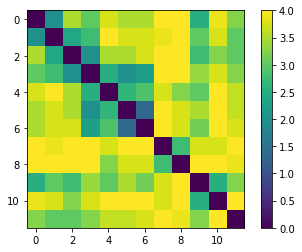

In [28]:
A = np.load(PWD + 'penalty_matrix.npy')
plt.imshow(A)
plt.colorbar()

In [29]:
# make a custom metric for evaluation
def score(y_true,y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0,y_true.shape[0]):
        # penalty matrix[true class, predcited class] = value
        S -=A[y_true[i],y_pred[i]] # [1,1]=0 , [1,4] = 4 ---> 
    return S/y_true.shape[0]

In [30]:
def  show_evaluation(pred,true):
    print (f'Default score: {score(true,pred)}')
    print (f'Accuracy score: {accuracy_score(true,pred)}')
    print (f'F1 score: {f1_score(true,pred)}')

In [31]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score

In [32]:
split = 10
kf = StratifiedKFold(n_splits=split,shuffle=True)

In [33]:
model = xgb.XGBClassifier(n_estimators = 100,max_depth=10,booster='gbtree',
                         objective='softprob',learning_rate=0.1,random_state=0,
                         subsample=0.9,colsample_bytree=0.9,tree_method='gpu_hist',
                         eval_metric = 'mlogloss',reg_lamdba=1500)

In [38]:
valid1_pred = np.zeros((len(valid_1),12))
valid2_pred = np.zeros((len(valid_2),12))
valid3_pred = np.zeros((len(valid_3),12))

In [36]:
litho = litho.astype(int)

In [39]:
# implementing the CV loop

i = 1
for (train_index,test_index) in kf.split(aug_train,litho):
    print (train_index.shape,test_index.shape)
    print(train_index,test_index)
    
    X_train,X_test = train.iloc[train_index],train.iloc[test_index]
    Y_train,Y_test = litho.iloc[train_index],litho.iloc[test_index]
    
    model.fit(X_train,Y_train,early_stopping_rounds=100,eval_set=[(X_test,Y_test)],verbose=1)
    
    predictions_1 = model.predict(aug_valid1)
    predictions_2 = model.predict(aug_valid_2)
    predictions_3 = model.predict(aug_valid_3)
    
    print (show_evaluation(predictions_1,valid_1_lithology))
    print (show_evaluation(predictions_2,valid_2_lithology))
    print (show_evaluation(predictions_3,valid_3_lithology))
    
    print (f'----------------------FOLD {i}-------------------')
    
    
    i+=1
    
    valid1_pred += model.predict_proba(aug_valid1)
    valid2_pred += model.predict_proba(aug_valid2)
    valid3_pred += model.predict_proba(aug_valid3)

(872912,) (96991,)
[     0      1      2 ... 969900 969901 969902] [    37     38     51 ... 969862 969868 969891]
[0]	validation_0-mlogloss:1.90465
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[1]	validation_0-mlogloss:1.58924
[2]	validation_0-mlogloss:1.35899
[3]	validation_0-mlogloss:1.18978
[4]	validation_0-mlogloss:1.05159
[5]	validation_0-mlogloss:0.934462
[6]	validation_0-mlogloss:0.829113
[7]	validation_0-mlogloss:0.738398
[8]	validation_0-mlogloss:0.659579
[9]	validation_0-mlogloss:0.590412
[10]	validation_0-mlogloss:0.531253
[11]	validation_0-mlogloss:0.478715
[12]	validation_0-mlogloss:0.432945
[13]	validation_0-mlogloss:0.389653
[14]	validation_0-mlogloss:0.351678
[15]	validation_0-mlogloss:0.319679
[16]	validation_0-mlogloss:0.288234
[17]	validation_0-mlogloss:0.260041
[18]	validation_0-mlogloss:0.234666
[19]	validation_0-mlogloss:0.211846
[20]	validation_0-mlogloss:0.192745
[21]	validation_0-mlogloss:0.174117
[22]	validation_0-mlogloss:0.158209
[2

ValueError: ignored

In [41]:
aug_valid1.shape

(125162, 116)

In [ ]:
aug_valid1

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.89208159e+03, 4.96651781e+05, 6.73979950e+06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.89223359e+03, 4.96651906e+05, 6.73979950e+06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.12540779e+03, 4.44186906e+05, 6.43559800e+06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.12555979e+03, 4.44186906e+05, 6.43559800e+06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.12571179e+03, 4.44186906e+05, 6.43559800e+06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
import xgboost as xgb